# 한국은행 의사록 어조 분석

이제 극성사전이 완성되었으므로, 이를 이용해 한국은행 의사록의 어조(tone)을 측정하도록 한다. 

우선 각 일자의 한국은행 의사록을 `sentences`로 분리한 뒤, 각 `sentences`를 다시 `ngrams`로 분리한다. 

문장별로 추출한 `ngrams`를 바탕으로 각 문장의 `tone_sentence`를 계산한다. 

문장별 `tone_sentence`가 계산됐으면, 문장을 다시 합쳐 문서(의사록)의 `tone_doc`을 구한다. 

한 날짜에는 한 문서가 있고, 따라서 한 `tone_doc`이 있으므로, 이제 이 데이터를 바탕으로 한국은행 기준금리 데이터와의 상관관계와 그래프를 확인한다. 

In [12]:
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import multiprocessing as mp

import preprocessing_mp_worker as worker

## 의사록 데이터를 불러온다. 

In [82]:
minutes_df = pd.read_pickle('./data_files/BOK_minutes/pkl/minutes_ngram.pkl')
minutes_df = minutes_df[['date', 'minutes']]
minutes_df.head()

date                                            minutes
0  2005-06-09  \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
1  2005-06-23  \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
2  2005-07-07  \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
3  2005-08-11  \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
4  2005-09-08  \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...

## 각 의사록(`minutes`)을 문장(`sentences`)들로 분리한다. 

In [83]:
%%time

minutes_df.loc[:, 'sentences'] = minutes_df.minutes.map(lambda x: worker.tidy_sentences(x)[0])

Wall time: 751 ms


In [84]:
minutes_df = minutes_df.explode('sentences')
minutes_df.head()

date                                            minutes  \
0  2005-06-09  \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...   
0  2005-06-09  \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...   
0  2005-06-09  \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...   
0  2005-06-09  \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...   
0  2005-06-09  \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...   

                                           sentences  
0                                           130.1...  
0  5. 참 여 자     이 상 용  감사                 정 규 영  ...  
0  (３) 위원 토의내용     ｢국내외 경제동향｣과 관련하여, 일부 위원은 최근 소비...  
0  동 위원은 서울 강남에서 시작된 부동산가격 상승이 다른 지역으로 확산될   기미가 ...  
0           또한 동 위원은 정부가 여러 차례에 걸쳐 부동산시장 안정대책을 내놓았음.

In [85]:
minutes_df.dropna(inplace=True) # sentences가 np.nan이라서 float으로 들어가 오류나는 경우 존재한다. 
minutes_df.date = pd.to_datetime(minutes_df.date)
minutes_df.reset_index(drop=True, inplace=True)

In [86]:
len(minutes_df)

42661

In [87]:
minutes_df.describe()

date  \
count                 42661   
unique                  297   
top     2018-10-18 00:00:00   
freq                    451   
first   2005-06-09 00:00:00   
last    2020-01-17 00:00:00   

                                                  minutes sentences  
count                                               42661     42661  
unique                                                297     41345  
top     \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...        다.  
freq                                                  451       231  
first                                                 NaN       NaN  
last                                                  NaN       NaN

In [88]:
minutes_df.head()

date                                            minutes  \
0 2005-06-09  \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...   
1 2005-06-09  \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...   
2 2005-06-09  \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...   
3 2005-06-09  \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...   
4 2005-06-09  \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...   

                                           sentences  
0                                           130.1...  
1  5. 참 여 자     이 상 용  감사                 정 규 영  ...  
2  (３) 위원 토의내용     ｢국내외 경제동향｣과 관련하여, 일부 위원은 최근 소비...  
3  동 위원은 서울 강남에서 시작된 부동산가격 상승이 다른 지역으로 확산될   기미가 ...  
4           또한 동 위원은 정부가 여러 차례에 걸쳐 부동산시장 안정대책을 내놓았음.

## 각 문장을 `ngrams`로 분리한다. 

In [34]:
%%time # Wall time: 42min 39s

with mp.Pool(processes=6) as p:
    minutes_sentences_ngrams = p.map(worker.text2ngram, minutes_df.sentences)

Wall time: 42min 39s


In [35]:
len(minutes_sentences_ngrams)

42661

## Polarity Dictionary를 불러온다. 

그리고 hawkish_dictionary와 dovish_dictionary로 나눈다. 

In [39]:
polarity_dictionary = pd.read_pickle('./data_files/results/polarity_dictionary_1.3threshold.pkl')
polarity_dictionary.head()

hawkish  dovish  total  prob_feature_given_hawkish  \
이변/NNG            9       7     16                    0.000008   
지신/NNG           12       8     20                    0.000010   
그렉시트/NNG         17      34     51                    0.000014   
실험/NNG           19       9     28                    0.000016   
자산배분전략/NNG       10     102    112                    0.000008   

            prob_feature_given_dovish  polarity_score  
이변/NNG                       0.000005        1.556266  
지신/NNG                       0.000006        1.815644  
그렉시트/NNG                     0.000024        0.605215  
실험/NNG                       0.000006        2.555350  
자산배분전략/NNG                   0.000071        0.118670

In [43]:
intensity_threshold = 1.3

hawkish_dictionary = polarity_dictionary[polarity_dictionary.polarity_score >= intensity_threshold]
hawkish_dictionary = hawkish_dictionary.index

dovish_dictionary = polarity_dictionary[polarity_dictionary.polarity_score <= 1/intensity_threshold]
dovish_dictionary = dovish_dictionary.index

## 각 문장의 tone을 구한다. 

In [48]:
def sentence_tone(sentence_ngram_list):
    hawkish_count = 0
    dovish_count = 0
    
    for ngram in sentence_ngram_list:
        if ngram in hawkish_dictionary:
            hawkish_count += 1
        elif ngram in dovish_dictionary:
            dovish_count += 1
        else:
            continue
    
    if (hawkish_count + dovish_count) == 0:
        return np.nan
    
    sentence_tone = (hawkish_count - dovish_count) / (hawkish_count + dovish_count)
    
    return sentence_tone

In [49]:
sentence_tone_list = [sentence_tone(ngram_list) for ngram_list in minutes_sentences_ngrams]
len(sentence_tone_list)

42661

In [95]:
sentence_tone_df = pd.DataFrame(sentence_tone_list, columns=['sentence_tone'])
minutes_df_tone = pd.concat([minutes_df, sentence_tone_df], axis=1)

In [109]:
minutes_df_tone.to_pickle('./data_files/results/minutes_df_sentence_tone.pkl')

## 문서의 tone을 구한다. 

`.groupby('date')`를 했다. 한 날짜에 의사록이 하나 올라온다 가정. 

In [108]:
minutes_df_tone_by_date = minutes_df_tone.groupby('date')['sentence_tone'].sum()
minutes_df_tone_by_date = pd.DataFrame({'doc_tone': minutes_df_tone_by_date.values}, index=minutes_df_tone_by_date.index)
minutes_df_tone_by_date.head()

doc_tone
date                 
2005-06-09  52.590981
2005-06-23  -1.663781
2005-07-07  45.713487
2005-08-11  70.147718
2005-09-08  38.087451

In [110]:
minutes_df_tone_by_date.to_pickle('./data_files/results/minutes_df_document_tone.pkl')

## 한국은행 기준금리 데이터를 불러와 합친다. 

In [2]:
minutes_df_tone_by_date = pd.read_pickle('./data_files/results/minutes_df_document_tone.pkl')
minutes_df_tone_by_date.head()

doc_tone
date                 
2005-06-09  52.590981
2005-06-23  -1.663781
2005-07-07  45.713487
2005-08-11  70.147718
2005-09-08  38.087451

In [3]:
bok_policy_rate = pd.read_csv('./data_files/BOK_2.6._base_rate.csv')
bok_policy_rate.date = pd.to_datetime(bok_policy_rate.date)
bok_policy_rate.set_index('date', inplace=True)
bok_policy_rate.head()

base_rate
date                 
2004-01-01       3.75
2004-01-02       3.75
2004-01-03       3.75
2004-01-04       3.75
2004-01-05       3.75

In [4]:
tone_and_policy_rate_df = minutes_df_tone_by_date.merge(bok_policy_rate, how='left', left_index=True, right_index=True)
tone_and_policy_rate_df.head()

doc_tone  base_rate
date                            
2005-06-09  52.590981       3.25
2005-06-23  -1.663781       3.25
2005-07-07  45.713487       3.25
2005-08-11  70.147718       3.25
2005-09-08  38.087451       3.25

## 상관관계 계산 및 그래프 plot

In [5]:
tone_and_policy_rate_df.corr(method='pearson')

doc_tone  base_rate
doc_tone   1.000000   0.532323
base_rate  0.532323   1.000000

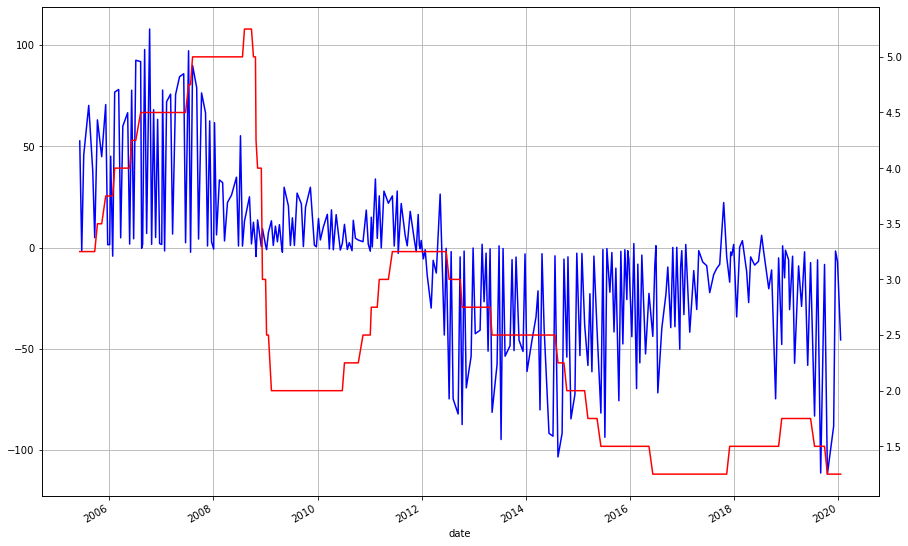

In [14]:
plt.figure(figsize=(15,10))

ax1 = tone_and_policy_rate_df.doc_tone.plot(color='blue', grid=True, label='금통위 의사록 어조')
ax2 = tone_and_policy_rate_df.base_rate.plot(color='red', grid=True, secondary_y=True, label='기준금리')

plt.show()